In [ ]:
# First POC to check if notes data is learnable in vanilla mode - SUCCESS

In [3]:
%load_ext autoreload
%autoreload 2

In [32]:
import torch
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(1)


In [37]:
import sys
from collections import Counter
#sys.path.append('/home/pau/Medical-Diagnosis-Learning/src')
sys.path.append('/home/ag4508/Medical-Diagnosis-Learning/src')
from data_util import *
from util_icu_train import get_labels

# easy_label_map = {"4019":0, "V290":1}
# training_set = load_data_csv('../notes_sample.csv', easy_label_map)

easy_label_map = get_labels('/misc/vlgscratch2/LecunGroup/anant/nlp/labels.txt')
training_set = load_data_csv('/misc/vlgscratch2/LecunGroup/anant/nlp/notes_sample_5class.csv', easy_label_map)
print("FD of labels:", Counter([_['label'] for _ in training_set]))

PADDING = "<PAD>"
UNKNOWN = "<UNK>"
max_seq_length = 20

# word_to_ix, vocab_size, word_counter = build_dictionary([training_set], PADDING, UNKNOWN)
# sentences_to_padded_index_sequences(word_to_ix, [training_set], max_seq_length, PADDING, UNKNOWN)


# of data samples:1088157
('FD of labels:', Counter({1: 382354, 4: 355998, 2: 273458, 3: 39712, 0: 36635}))


In [42]:
import numpy as np
print np.max([len(_['text'].split()) for _ in training_set])
print np.min([len(_['text'].split()) for _ in training_set])

751
0


In [31]:
from models import *
batch_size = 256
num_workers = 2
embed_dim = 50
hidden_dim = 100

val_set = training_set[int(0.8*len(training_set)):]
training_set = training_set[:int(0.8*len(training_set))]

train_loader = torch.utils.data.DataLoader(dataset= TextData(training_set), batch_size=batch_size, shuffle=True, 
                                                           num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(dataset= TextData(val_set), batch_size=batch_size, shuffle=True, 
                                                           num_workers=num_workers)

In [33]:
model = LSTMModel(vocab_size, embed_dim, hidden_dim, easy_label_map, batch_size, use_cuda)
opti = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
crit = nn.CrossEntropyLoss()

if use_cuda:
    model.cuda()
    crit.cuda()

from eval import *    

In [35]:

opti = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
step = 0
step_log = []
loss_log = []
val_acc_log = []
val_loss_log = []

for batch in train_loader:
    if batch[0].size(0) != batch_size:
        continue
    model.zero_grad()
    x = Variable(batch[0])
    y = Variable(batch[1].view(-1))
    if use_cuda:
        x, y = x.cuda(), y.cuda()

    hidden = model.init_hidden()
    x = model(x, hidden)
    loss = crit(x, y)
    loss.backward()
    opti.step()

    if step % 100 == 0:
        val_acc, val_loss = evaluate(model, val_loader, batch_size, crit, use_cuda)
        print("Step: %d, Loss: %.4f, Validation Acc: %.2f, Val loss: %.2f"%(step, loss.data[0], val_acc, val_loss))
        step_log.append(step)
        loss_log.append(loss.data[0])
        val_acc_log.append(val_acc)
        val_loss_log.append(val_loss)
    step += 1
#     if step == 20:
#         break


Step: 0, Loss: 1.6612, Validation Acc: 0.05, Val loss: 1.66
Step: 100, Loss: 1.3968, Validation Acc: 0.34, Val loss: 1.31
Step: 200, Loss: 1.3927, Validation Acc: 0.35, Val loss: 1.33
Step: 300, Loss: 1.3849, Validation Acc: 0.35, Val loss: 1.31
Step: 400, Loss: 1.2929, Validation Acc: 0.35, Val loss: 1.34
Step: 500, Loss: 1.3587, Validation Acc: 0.35, Val loss: 1.35
Step: 600, Loss: 1.3714, Validation Acc: 0.35, Val loss: 1.34
Step: 700, Loss: 1.3937, Validation Acc: 0.35, Val loss: 1.32
Step: 800, Loss: 1.3148, Validation Acc: 0.35, Val loss: 1.35
Step: 900, Loss: 1.3953, Validation Acc: 0.35, Val loss: 1.30
Step: 1000, Loss: 1.3489, Validation Acc: 0.35, Val loss: 1.23
Step: 1100, Loss: 1.3514, Validation Acc: 0.35, Val loss: 1.36
Step: 1200, Loss: 1.2984, Validation Acc: 0.35, Val loss: 1.37
Step: 1300, Loss: 1.2782, Validation Acc: 0.35, Val loss: 1.33
Step: 1400, Loss: 1.3553, Validation Acc: 0.35, Val loss: 1.30
Step: 1500, Loss: 1.3869, Validation Acc: 0.35, Val loss: 1.27
Step

/misc/vlgscratch2/LecunGroup/anant/anaconda3/envs/pyt/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


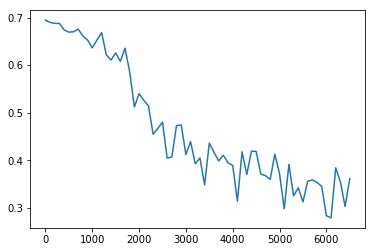

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(step_log, loss_log)

In [ ]:
'''
Step: 0, Loss: 0.6943, Validation Acc: 0.49, Val loss: 0.69
Step: 100, Loss: 0.6899, Validation Acc: 0.55, Val loss: 0.69
Step: 200, Loss: 0.6877, Validation Acc: 0.56, Val loss: 0.67
Step: 300, Loss: 0.6876, Validation Acc: 0.56, Val loss: 0.69
Step: 400, Loss: 0.6741, Validation Acc: 0.56, Val loss: 0.68
Step: 500, Loss: 0.6693, Validation Acc: 0.56, Val loss: 0.69
Step: 600, Loss: 0.6701, Validation Acc: 0.57, Val loss: 0.68
Step: 700, Loss: 0.6757, Validation Acc: 0.58, Val loss: 0.69
Step: 800, Loss: 0.6613, Validation Acc: 0.59, Val loss: 0.65
Step: 900, Loss: 0.6528, Validation Acc: 0.59, Val loss: 0.69
Step: 1000, Loss: 0.6364, Validation Acc: 0.62, Val loss: 0.68
Step: 1100, Loss: 0.6526, Validation Acc: 0.62, Val loss: 0.65
Step: 1200, Loss: 0.6682, Validation Acc: 0.63, Val loss: 0.64
Step: 1300, Loss: 0.6217, Validation Acc: 0.64, Val loss: 0.64
Step: 1400, Loss: 0.6107, Validation Acc: 0.66, Val loss: 0.63
Step: 1500, Loss: 0.6256, Validation Acc: 0.67, Val loss: 0.56
Step: 1600, Loss: 0.6079, Validation Acc: 0.69, Val loss: 0.61
Step: 1700, Loss: 0.6355, Validation Acc: 0.70, Val loss: 0.58
Step: 1800, Loss: 0.5854, Validation Acc: 0.72, Val loss: 0.54
Step: 1900, Loss: 0.5122, Validation Acc: 0.73, Val loss: 0.58
Step: 2000, Loss: 0.5400, Validation Acc: 0.74, Val loss: 0.50
Step: 2100, Loss: 0.5263, Validation Acc: 0.76, Val loss: 0.53
Step: 2200, Loss: 0.5145, Validation Acc: 0.77, Val loss: 0.43
Step: 2300, Loss: 0.4547, Validation Acc: 0.78, Val loss: 0.49
Step: 2400, Loss: 0.4670, Validation Acc: 0.78, Val loss: 0.44
Step: 2500, Loss: 0.4803, Validation Acc: 0.78, Val loss: 0.37
Step: 2600, Loss: 0.4047, Validation Acc: 0.79, Val loss: 0.56
Step: 2700, Loss: 0.4070, Validation Acc: 0.80, Val loss: 0.43
Step: 2800, Loss: 0.4729, Validation Acc: 0.80, Val loss: 0.45
Step: 2900, Loss: 0.4743, Validation Acc: 0.80, Val loss: 0.40
Step: 3000, Loss: 0.4122, Validation Acc: 0.80, Val loss: 0.42
Step: 3100, Loss: 0.4392, Validation Acc: 0.79, Val loss: 0.43
Step: 3200, Loss: 0.3928, Validation Acc: 0.82, Val loss: 0.39
Step: 3300, Loss: 0.4052, Validation Acc: 0.81, Val loss: 0.43
Step: 3400, Loss: 0.3485, Validation Acc: 0.80, Val loss: 0.48
Step: 3500, Loss: 0.4364, Validation Acc: 0.80, Val loss: 0.38
Step: 3600, Loss: 0.4169, Validation Acc: 0.82, Val loss: 0.39
Step: 3700, Loss: 0.3988, Validation Acc: 0.83, Val loss: 0.39
Step: 3800, Loss: 0.4106, Validation Acc: 0.80, Val loss: 0.44
Step: 3900, Loss: 0.3948, Validation Acc: 0.82, Val loss: 0.41
Step: 4000, Loss: 0.3893, Validation Acc: 0.83, Val loss: 0.39
Step: 4100, Loss: 0.3142, Validation Acc: 0.83, Val loss: 0.37
Step: 4200, Loss: 0.4178, Validation Acc: 0.83, Val loss: 0.34
Step: 4300, Loss: 0.3702, Validation Acc: 0.84, Val loss: 0.39
Step: 4400, Loss: 0.4193, Validation Acc: 0.84, Val loss: 0.35
Step: 4500, Loss: 0.4188, Validation Acc: 0.83, Val loss: 0.44
Step: 4600, Loss: 0.3711, Validation Acc: 0.83, Val loss: 0.34
Step: 4700, Loss: 0.3680, Validation Acc: 0.84, Val loss: 0.41
Step: 4800, Loss: 0.3597, Validation Acc: 0.84, Val loss: 0.42
Step: 4900, Loss: 0.4132, Validation Acc: 0.84, Val loss: 0.37
Step: 5000, Loss: 0.3717, Validation Acc: 0.84, Val loss: 0.34
Step: 5100, Loss: 0.2982, Validation Acc: 0.84, Val loss: 0.43
Step: 5200, Loss: 0.3917, Validation Acc: 0.84, Val loss: 0.37
Step: 5300, Loss: 0.3253, Validation Acc: 0.84, Val loss: 0.36
Step: 5400, Loss: 0.3423, Validation Acc: 0.85, Val loss: 0.34
Step: 5500, Loss: 0.3126, Validation Acc: 0.85, Val loss: 0.33
Step: 5600, Loss: 0.3560, Validation Acc: 0.85, Val loss: 0.39
Step: 5700, Loss: 0.3589, Validation Acc: 0.85, Val loss: 0.32
Step: 5800, Loss: 0.3535, Validation Acc: 0.85, Val loss: 0.31
Step: 5900, Loss: 0.3453, Validation Acc: 0.85, Val loss: 0.29
Step: 6000, Loss: 0.2837, Validation Acc: 0.85, Val loss: 0.32
Step: 6100, Loss: 0.2790, Validation Acc: 0.84, Val loss: 0.37
Step: 6200, Loss: 0.3843, Validation Acc: 0.86, Val loss: 0.30
Step: 6300, Loss: 0.3545, Validation Acc: 0.85, Val loss: 0.32
Step: 6400, Loss: 0.3030, Validation Acc: 0.85, Val loss: 0.31
Step: 6500, Loss: 0.3615, Validation Acc: 0.85, Val loss: 0.30
'''